In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

##### Input Files
Modify path and files as needed.

In [47]:
# User inputs (modify paths if needed)
relpath = 'data/modelTraining'
file_gs1 = 'gs1_3dayT.csv'
file_ws1 = 'ws1_3dayT.csv'
file_rpi = 'rpi_11day.csv'

## Function Definitions
-------------------------

In [48]:
def safe_datetime_parse(filepath, timestamp_col):
    """Safely parse datetime with multiple format attempts"""
    try:
        df = pd.read_csv(filepath)
        if timestamp_col not in df.columns:
            print(f"Warning: '{timestamp_col}' not found in {filepath}")
            return None
        try:
            df[timestamp_col] = pd.to_datetime(df[timestamp_col])
        except Exception:
            print(f"Error: Could not parse timestamps in {filepath}")
            return None
        return df
    except FileNotFoundError:
        print(f"Error: File {filepath} not found")
        return None
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None


In [49]:
def load_and_validate_data(relpath, file_gs1, file_ws1, file_rpi):
    """Load GS1, WS1, and RPi data"""
    gs1 = safe_datetime_parse(f"{relpath}/{file_gs1}", 'created_at')
    ws1 = safe_datetime_parse(f"{relpath}/{file_ws1}", 'created_at')
    rpi = safe_datetime_parse(f"{relpath}/{file_rpi}", 'Timestamp')
    return gs1, ws1, rpi


In [50]:
def clean_sensor_data(gs1, ws1, rpi):
    """Clean and standardize sensor data"""
    # GS1
    tcols = [c for c in gs1.columns if 'temp' in c.lower()]
    hcols = [c for c in gs1.columns if 'hum' in c.lower()]
    gs1c = gs1[['created_at', tcols[0], hcols[0]]].copy()
    gs1c.columns = ['Timestamp', 'Temperature (°C)', 'Humidity (%)']
    
    # WS1
    lcols = [c for c in ws1.columns if 'light' in c.lower()]
    ws1c = ws1[['created_at', lcols[0]]].copy()
    ws1c.columns = ['Timestamp', 'Ambient Light (lux)']
    
    # RPi assumed to have all
    rpic = rpi[['Timestamp', 'Temperature (°C)', 'Humidity (%)', 'Ambient Light (lux)']].copy()
    
    # Convert Timestamp to datetime if not already
    for df in (gs1c, ws1c, rpic):
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    return gs1c, ws1c, rpic



In [51]:
def normalize_timestamps(gs1c, ws1c, rpic):
    """Normalize timestamps to UTC and floor to minute"""
    for df in (gs1c, ws1c):
        df['Timestamp'] = df['Timestamp'].dt.tz_convert('UTC').dt.tz_localize(None)
        df['minute_ts'] = df['Timestamp'].dt.floor('min')
    rpic['minute_ts'] = rpic['Timestamp'].dt.tz_localize('America/New_York') \
                                        .dt.tz_convert('UTC') \
                                        .dt.tz_localize(None) \
                                        .dt.floor('min')
    return gs1c, ws1c, rpic


In [52]:
def aggregate_by_minute(df, prefix, sensors):
    agg = {}
    if 'temperature' in sensors and 'Temperature (°C)' in df.columns:
        agg['Temperature (°C)'] = 'mean'
    if 'humidity' in sensors and 'Humidity (%)' in df.columns:
        agg['Humidity (%)'] = 'mean'
    if 'light' in sensors and 'Ambient Light (lux)' in df.columns:
        agg['Ambient Light (lux)'] = 'mean'
    grp = df.groupby('minute_ts').agg(agg).reset_index()
    # rename
    rename = {'Temperature (°C)': f'Temperature_{prefix}',
              'Humidity (%)': f'Humidity_{prefix}',
              'Ambient Light (lux)': f'Ambient_Light_{prefix}'}
    return grp.rename(columns=rename)


In [53]:
def merge_sensor_data(gs1_agg, ws1_agg, rpi_agg):
    fused = rpi_agg.merge(gs1_agg, on='minute_ts', how='inner') \
                  .merge(ws1_agg, on='minute_ts', how='inner')
    fused.set_index('minute_ts', inplace=True)
    fused = fused.dropna()
    return fused


In [54]:
def perform_calibration(fused_data):
    """Train calibration models with a train/test split and return performance metrics"""
    # Define models to evaluate
    models = {
        'linear_regression': LinearRegression(),
        'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'xgboost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
    }
    calibration_results = {}

    # Identify features based on RPI columns
    features = set(col.replace('_RPI','').lower() for col in fused_data.columns if col.endswith('_RPI'))

    for feat in features:
        col_rpi = f"{feat.title()}_RPI"
        # Determine reference column
        ref_cols = [f"{feat.title()}_GS1", f"{feat.title()}_WS1"]
        col_ref = next((c for c in ref_cols if c in fused_data.columns), None)
        if col_ref is None:
            continue

        # Prepare data and split
        df = fused_data[[col_rpi, col_ref]].dropna()
        X = df[[col_rpi]].values
        y = df[col_ref].values
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X, y, df.index, test_size=0.2, random_state=42
        )

        calibration_results[feat] = {}
        for method, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Store predictions back into the DataFrame for visualization
            pred_col = f"{feat.title()}_RPI_{method}"
            fused_data.loc[idx_test, pred_col] = y_pred

            # Calculate metrics on test set
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            ev = explained_variance_score(y_test, y_pred)

            calibration_results[feat][method] = {
                'mse': mse,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'explained_variance': ev
            }

    return fused_data, calibration_results

## Data Preprocessing
--------------------------

In [55]:
# Load data
gs1, ws1, rpi = load_and_validate_data(relpath, file_gs1, file_ws1, file_rpi)
print(f"Dataset lengths:\nGS1: {len(gs1)}, WS1: {len(ws1)}, RPi: {len(rpi)}")

display(gs1.head(), ws1.head(), rpi.head())


Dataset lengths:
GS1: 11513, WS1: 14295, RPi: 25784


,created_at,field1(Temperature ºC ),field2(Humidity),field3(Voltage),field4(WIFI RSSI),field5,field6,field7,field8,field9,...,status,lat,long,elev,wifi,cell,serial,log,wifi_loc,cell_loc
0,2025-06-11 00:00:26-04:00,22.9652,66.9917,3.737,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,HF8PM1TGS1A,NaN,NaN,NaN
1,2025-06-11 00:00:28-04:00,NaN,NaN,NaN,-57.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,HF8PM1TGS1A,NaN,NaN,NaN
2,2025-06-11 00:01:27-04:00,22.9652,66.9825,3.737,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,HF8PM1TGS1A,NaN,NaN,NaN
3,2025-06-11 00:01:29-04:00,NaN,NaN,NaN,-57.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,HF8PM1TGS1A,NaN,NaN,NaN
4,2025-06-11 00:02:27-04:00,22.9492,67.0008,3.737,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,HF8PM1TGS1A,NaN,NaN,NaN


,created_at,field1(Temperature ºC ),field2(Humidity),field3(Light),field4(Voltage),field5(WIFI RSSI),field6(),field7(),field8(External Temperature Probe ºC ),field9(),...,lat,long,elev,wifi,cell,serial,log,wifi_loc,cell_loc,vfield1
0,2025-06-11 00:00:26-04:00,25.3632,58.1155,0.75,2.3754,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,KYAF43XWS1A,NaN,NaN,NaN,25.47
1,2025-06-11 00:00:30-04:00,NaN,NaN,NaN,NaN,-47.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,KYAF43XWS1A,NaN,NaN,NaN,NaN
2,2025-06-11 00:01:26-04:00,25.3632,58.2116,0.75,2.3754,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,KYAF43XWS1A,NaN,NaN,NaN,25.48
3,2025-06-11 00:01:30-04:00,NaN,NaN,NaN,NaN,-47.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,KYAF43XWS1A,NaN,NaN,NaN,NaN
4,2025-06-11 00:02:26-04:00,25.3765,58.1384,0.75,2.3754,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,KYAF43XWS1A,NaN,NaN,NaN,25.49


,Timestamp,Temperature (°C),Humidity (%),Pressure (hPa),Gas Resistance (Ω),Violet (450nm),Blue (500nm),Green (550nm),Yellow (570nm),Orange (600nm),Red (650nm),Ambient Light (lux)
0,2025-06-11 17:16:33,22.76,51.60,1014.64,102400000.0,5.87,3.85,9.09,7.64,0.00,0.0,406.43
1,2025-06-11 17:17:33,22.76,51.58,1014.62,102400000.0,7.04,5.13,10.23,8.60,12.97,6.3,405.89
2,2025-06-11 17:18:34,22.76,51.60,1014.63,102400000.0,7.04,5.13,10.23,8.60,12.97,7.2,405.89
3,2025-06-11 17:19:34,22.74,51.69,1014.62,102400000.0,7.04,5.13,10.23,8.60,12.97,7.2,405.35
4,2025-06-11 17:20:34,22.72,51.79,1014.62,102400000.0,7.04,5.13,10.23,8.60,12.97,7.2,404.81


In [56]:
# Clean
gs1c, ws1c, rpic = clean_sensor_data(gs1, ws1, rpi)
display(gs1c.head(), ws1c.head(), rpic.head())

,Timestamp,Temperature (°C),Humidity (%)
0,2025-06-11 00:00:26-04:00,22.9652,66.9917
1,2025-06-11 00:00:28-04:00,NaN,NaN
2,2025-06-11 00:01:27-04:00,22.9652,66.9825
3,2025-06-11 00:01:29-04:00,NaN,NaN
4,2025-06-11 00:02:27-04:00,22.9492,67.0008


,Timestamp,Ambient Light (lux)
0,2025-06-11 00:00:26-04:00,0.75
1,2025-06-11 00:00:30-04:00,NaN
2,2025-06-11 00:01:26-04:00,0.75
3,2025-06-11 00:01:30-04:00,NaN
4,2025-06-11 00:02:26-04:00,0.75


,Timestamp,Temperature (°C),Humidity (%),Ambient Light (lux)
0,2025-06-11 17:16:33,22.76,51.60,406.43
1,2025-06-11 17:17:33,22.76,51.58,405.89
2,2025-06-11 17:18:34,22.76,51.60,405.89
3,2025-06-11 17:19:34,22.74,51.69,405.35
4,2025-06-11 17:20:34,22.72,51.79,404.81


In [57]:
# Normalize
gs1n, ws1n, rpin = normalize_timestamps(gs1c, ws1c, rpic)

# Aggregate
gs1a = aggregate_by_minute(gs1n, 'GS1', ['temperature','humidity'])
ws1a = aggregate_by_minute(ws1n, 'WS1', ['light'])
rpia = aggregate_by_minute(rpin, 'RPI', ['temperature','humidity','light'])

# Merge
fused = merge_sensor_data(gs1a, ws1a, rpia)
display(fused.head())

,Temperature_RPI,Humidity_RPI,Ambient_Light_RPI,Temperature_GS1,Humidity_GS1,Ambient_Light_WS1
minute_ts,,,,,,
2025-06-11 21:16:00,22.76,51.60,406.43,22.1908,56.4858,414.30
2025-06-11 21:17:00,22.76,51.58,405.89,22.1748,56.5286,414.60
2025-06-11 21:18:00,22.76,51.60,405.89,22.1614,56.5591,414.30
2025-06-11 21:19:00,22.74,51.69,405.35,22.1748,56.5377,413.25
2025-06-11 21:20:00,22.72,51.79,404.81,22.1748,56.5499,412.95


In [58]:
# Calibrate
fused_data, calibration_results = perform_calibration(fused)

## Visualizations
--------------------------------

In [59]:
#Visualizations

"""Create comprehensive visualizations with improved plots"""

# Define available features based on data
features = {}
if all(col in fused_data.columns for col in ['Temperature_RPI', 'Temperature_GS1']):
    temp_cols = ['Temperature_RPI', 'Temperature_GS1']
    if 'Temperature_RPI_Calibrated' in fused_data.columns:
        temp_cols.append('Temperature_RPI_Calibrated')
    features['Temperature'] = temp_cols

if all(col in fused_data.columns for col in ['Humidity_RPI', 'Humidity_GS1']):
    hum_cols = ['Humidity_RPI', 'Humidity_GS1']
    if 'Humidity_RPI_Calibrated' in fused_data.columns:
        hum_cols.append('Humidity_RPI_Calibrated')
    features['Humidity'] = hum_cols

if all(col in fused_data.columns for col in ['Ambient_Light_RPI', 'Ambient_Light_WS1']):
    features['Ambient_Light'] = ['Ambient_Light_RPI', 'Ambient_Light_WS1']

### Exploratory Visualizations
---

Text(0.5, 1.0, 'Summary Statistics')

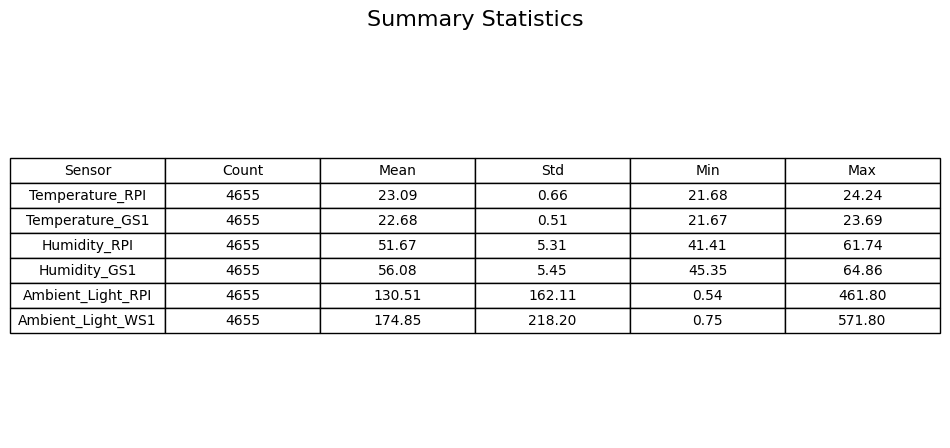

In [60]:
# 1. Summary statistics table
fig, ax = plt.subplots(figsize=(12, 0.5 + 0.5 * sum(len(m) for m in calibration_results.values())))
ax.axis('tight')
ax.axis('off')

summary_data = []
for feat, cols in features.items():
    for col in cols:
        data = fused_data[col].dropna()
        summary_data.append([
            col, len(data), f"{data.mean():.2f}", f"{data.std():.2f}",
            f"{data.min():.2f}", f"{data.max():.2f}"
        ])

table = ax.table(cellText=summary_data,
                colLabels=['Sensor', 'Count', 'Mean', 'Std', 'Min', 'Max'],
                cellLoc='center', loc='center')
table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1, 1.5)
plt.title('Summary Statistics', fontsize=16, pad=20)

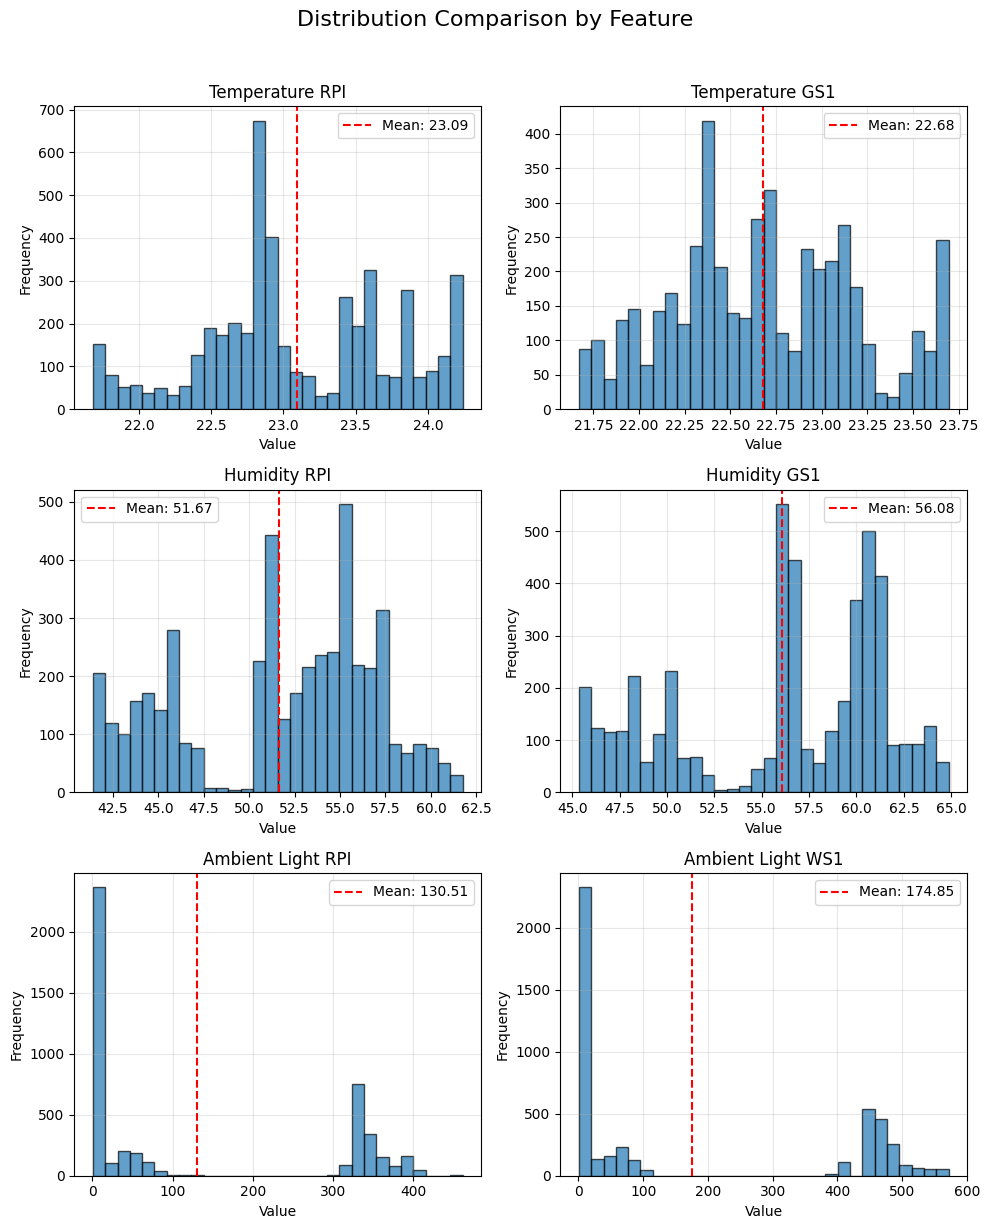

In [61]:
n_feats   = len(features)
max_cols  = max(len(cols) for cols in features.values())

fig, axes = plt.subplots(
    n_feats,
    max_cols,
    figsize=(5 * max_cols, 4 * n_feats),
    squeeze=False
)

for row_idx, (feat, cols) in enumerate(features.items()):
    for col_idx in range(max_cols):
        ax = axes[row_idx, col_idx]
        if col_idx < len(cols):
            col_name = cols[col_idx]
            data     = fused_data[col_name].dropna()
            
            # histogram + mean line
            ax.hist(data, bins=30, alpha=0.7, edgecolor='black')
            ax.axvline(
                data.mean(),
                color='red',
                linestyle='--',
                label=f"Mean: {data.mean():.2f}"
            )
            
            # labels & legend
            ax.set_title(col_name.replace('_', ' '))
            ax.set_xlabel("Value")
            ax.set_ylabel("Frequency")
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            # no data for this subplot
            ax.axis('off')

# global title
fig.suptitle("Distribution Comparison by Feature", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


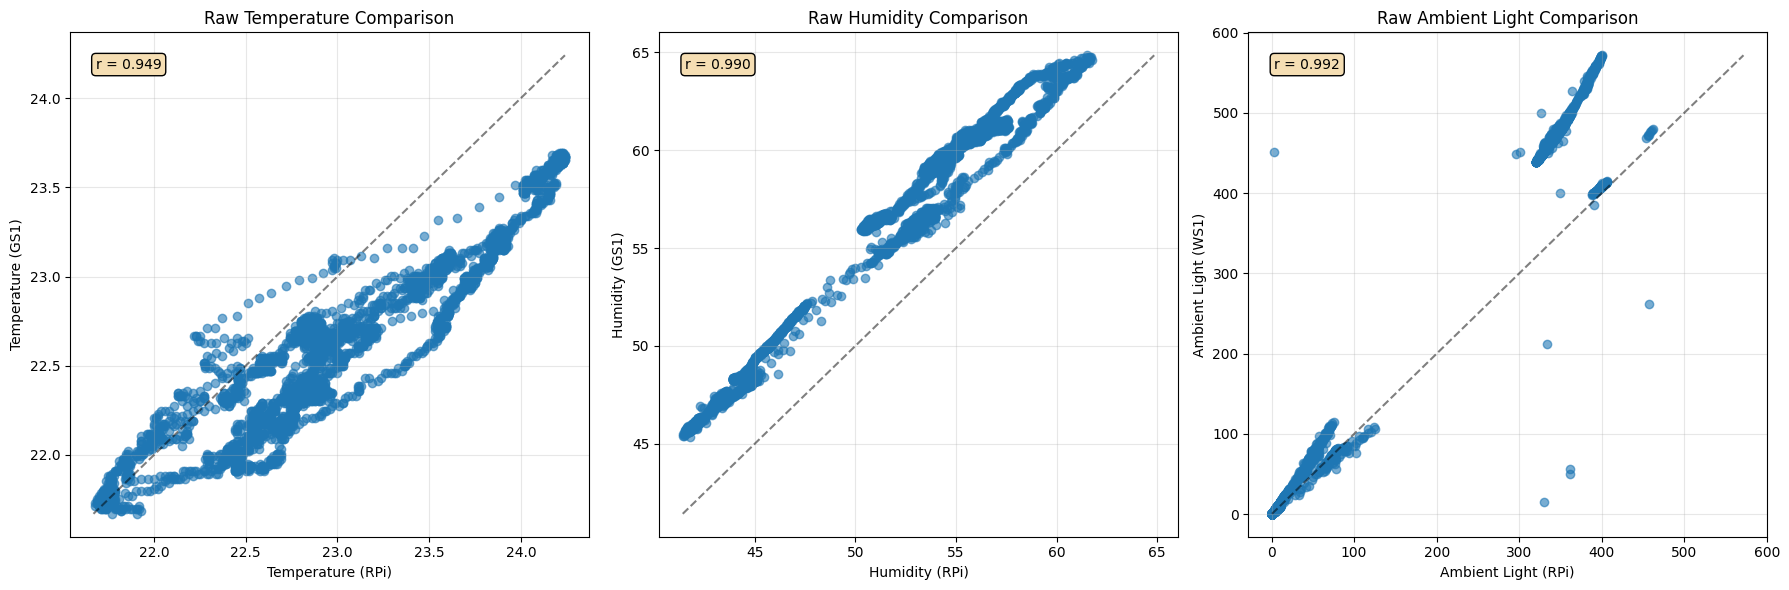

In [62]:
# Define which reference suffix to use for each feature
ref_map = {
    'Temperature': 'GS1',
    'Humidity':    'GS1',
    'Ambient_Light': 'WS1'
}

feats = ['Temperature', 'Humidity', 'Ambient_Light']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, feat in zip(axes, feats):
    rpi_col = f"{feat}_RPI"
    ref_col = f"{feat}_{ref_map[feat]}"
    
    # Align & drop NaNs
    df = fused_data[[rpi_col, ref_col]].dropna()
    x = df[rpi_col]
    y = df[ref_col]
    
    # Scatter
    ax.scatter(x, y, alpha=0.6)
    
    # 1:1 line
    vmin = min(x.min(), y.min())
    vmax = max(x.max(), y.max())
    ax.plot([vmin, vmax], [vmin, vmax], 'k--', alpha=0.5)
    
    # Correlation
    if len(x) > 1:
        corr = np.corrcoef(x, y)[0, 1]
        ax.text(0.05, 0.95, f'r = {corr:.3f}',
                transform=ax.transAxes, va='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='wheat'))
    
    # Labels & title
    label = feat.replace('_', ' ')
    ax.set_xlabel(f"{label} (RPi)")
    ax.set_ylabel(f"{label} ({ref_map[feat]})")
    ax.set_title(f"Raw {label} Comparison")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


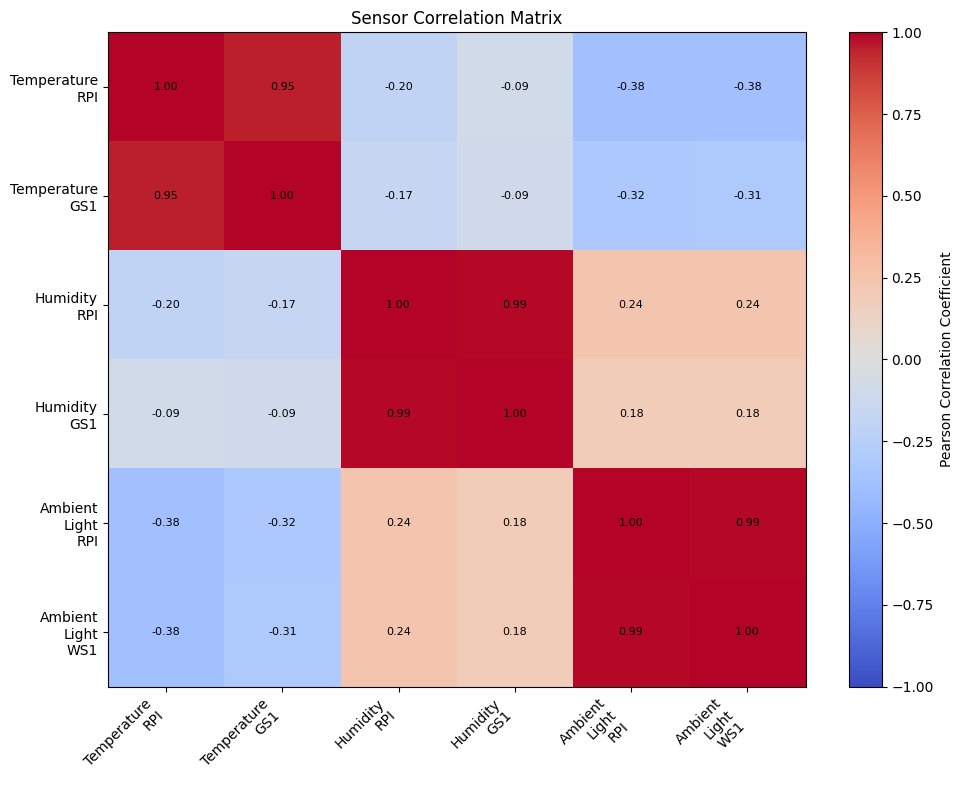

In [63]:
# 4. Enhanced correlation matrix
if len(features) > 0:
    all_cols = []
    for cols in features.values():
        all_cols.extend(cols)
    
    corr_data = fused_data[all_cols]
    corr_matrix = corr_data.corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_matrix.values, cmap='coolwarm', aspect='auto', 
                    vmin=-1, vmax=1)

    # Add text annotations
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix.columns)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=8)
    
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix)))
    ax.set_xticklabels([col.replace('_', '\n') for col in corr_matrix.columns], 
                        rotation=45, ha='right')
    ax.set_yticklabels([col.replace('_', '\n') for col in corr_matrix.index])
    
    plt.colorbar(im, ax=ax, label='Pearson Correlation Coefficient')
    plt.title("Sensor Correlation Matrix")
    plt.tight_layout()


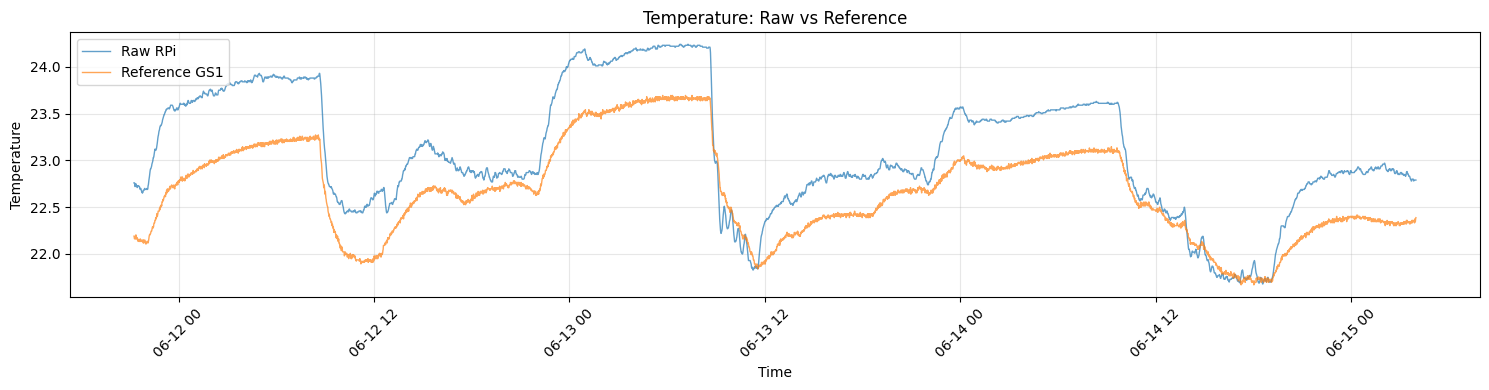

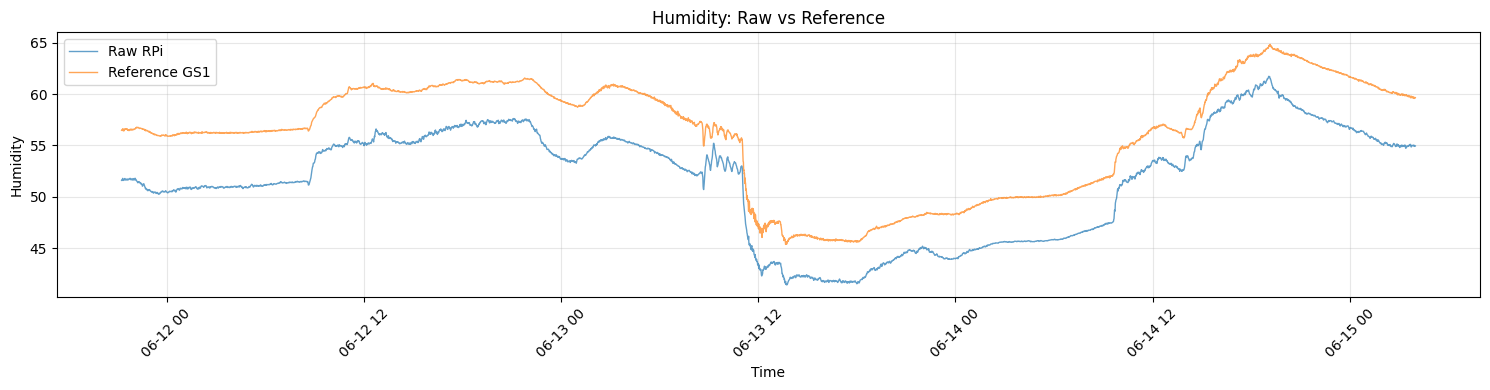

In [64]:
import matplotlib.pyplot as plt

for feat in ['Temperature', 'Humidity']:
    raw_col = f"{feat}_RPI"
    ref_col = f"{feat}_GS1"

    fig, ax = plt.subplots(figsize=(15, 4))

    # raw & reference
    ax.plot(fused_data.index, fused_data[raw_col],
            label='Raw RPi', linewidth=1, alpha=0.7)
    ax.plot(fused_data.index, fused_data[ref_col],
            label='Reference GS1', linewidth=1, alpha=0.7)

    # formatting
    ax.set_ylabel(feat)
    ax.set_xlabel("Time")
    ax.set_title(f"{feat}: Raw vs Reference")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


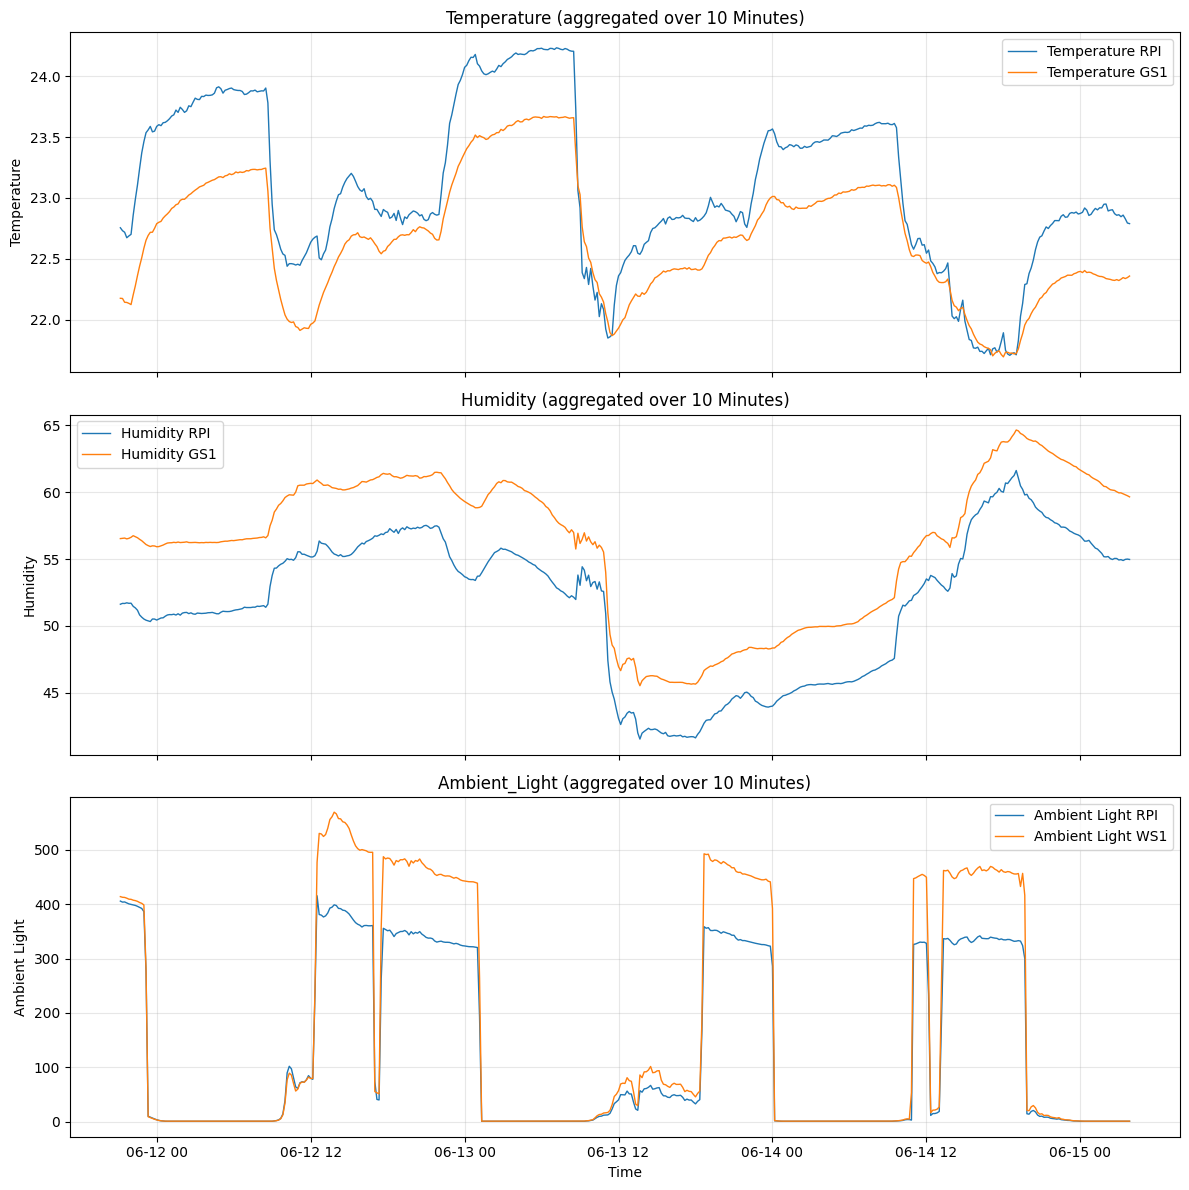

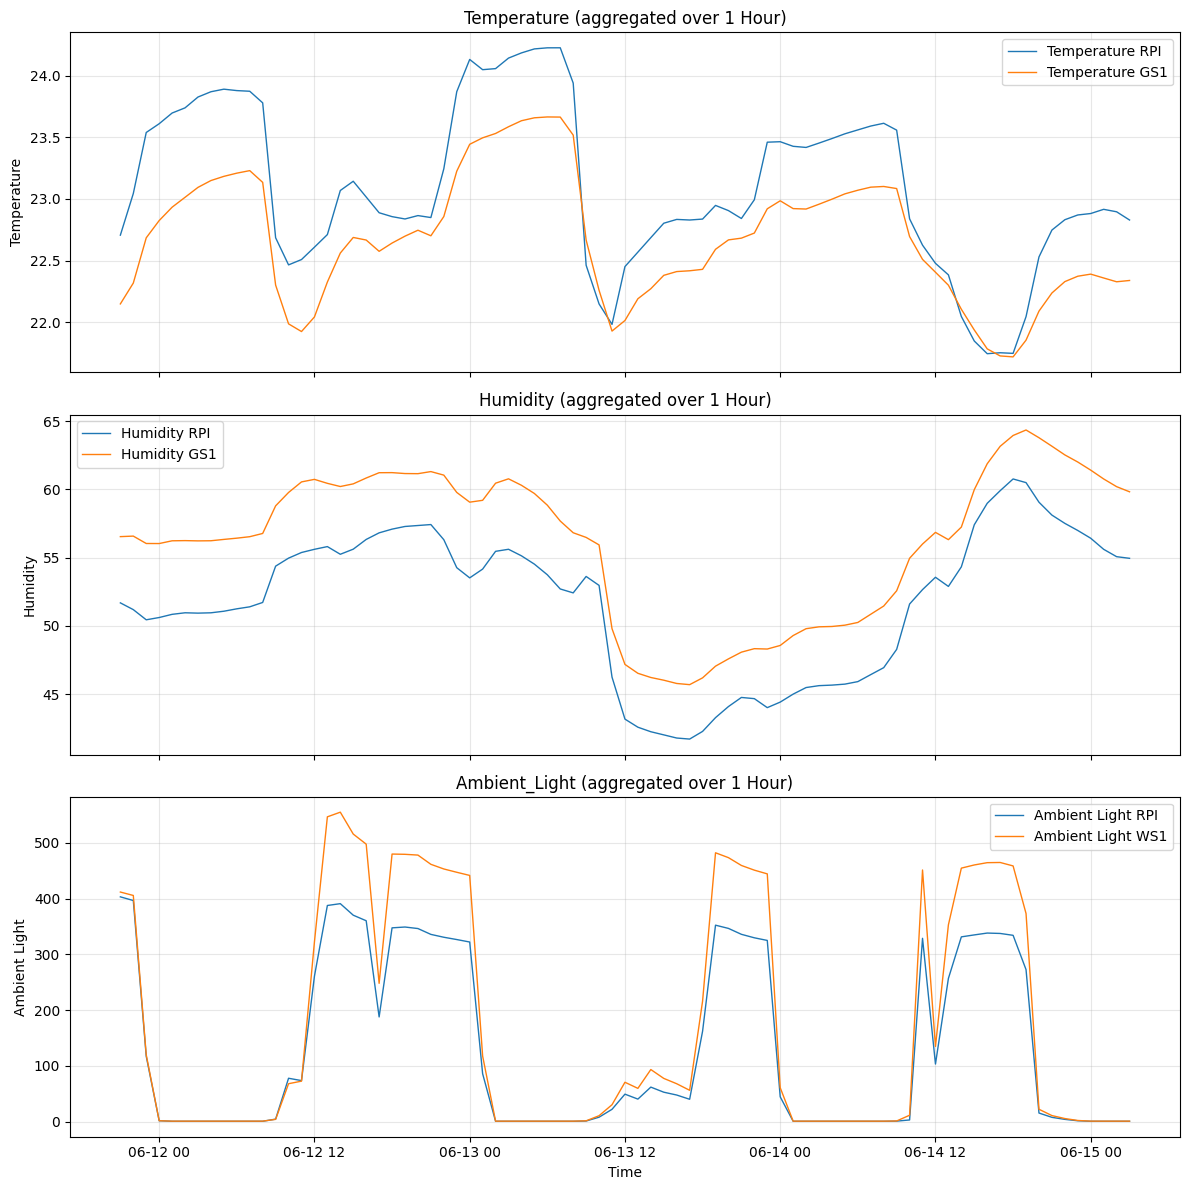

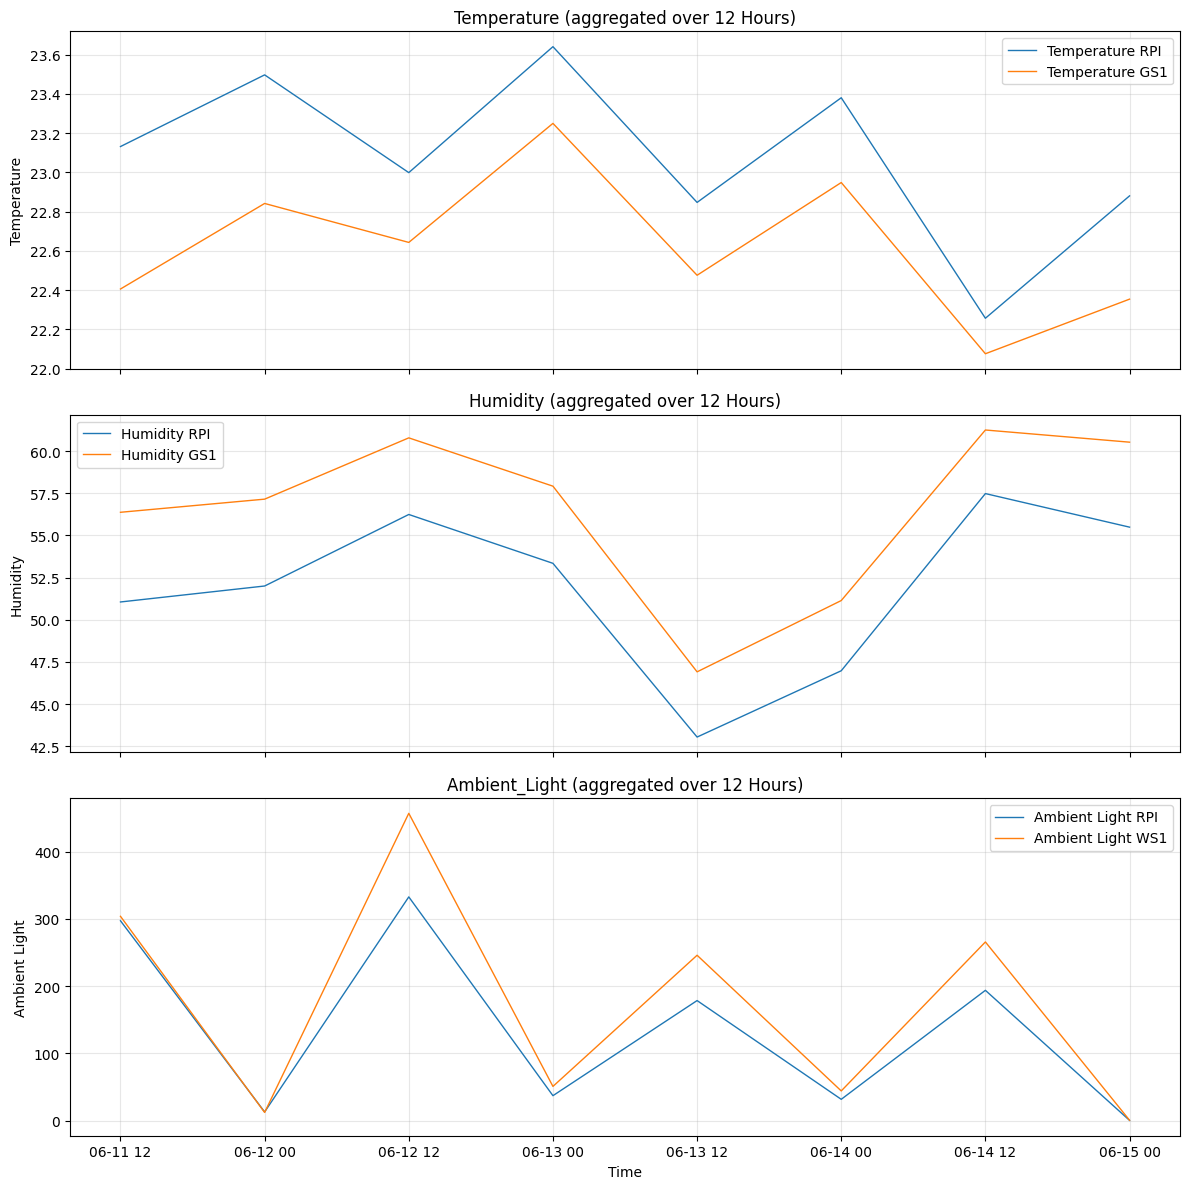

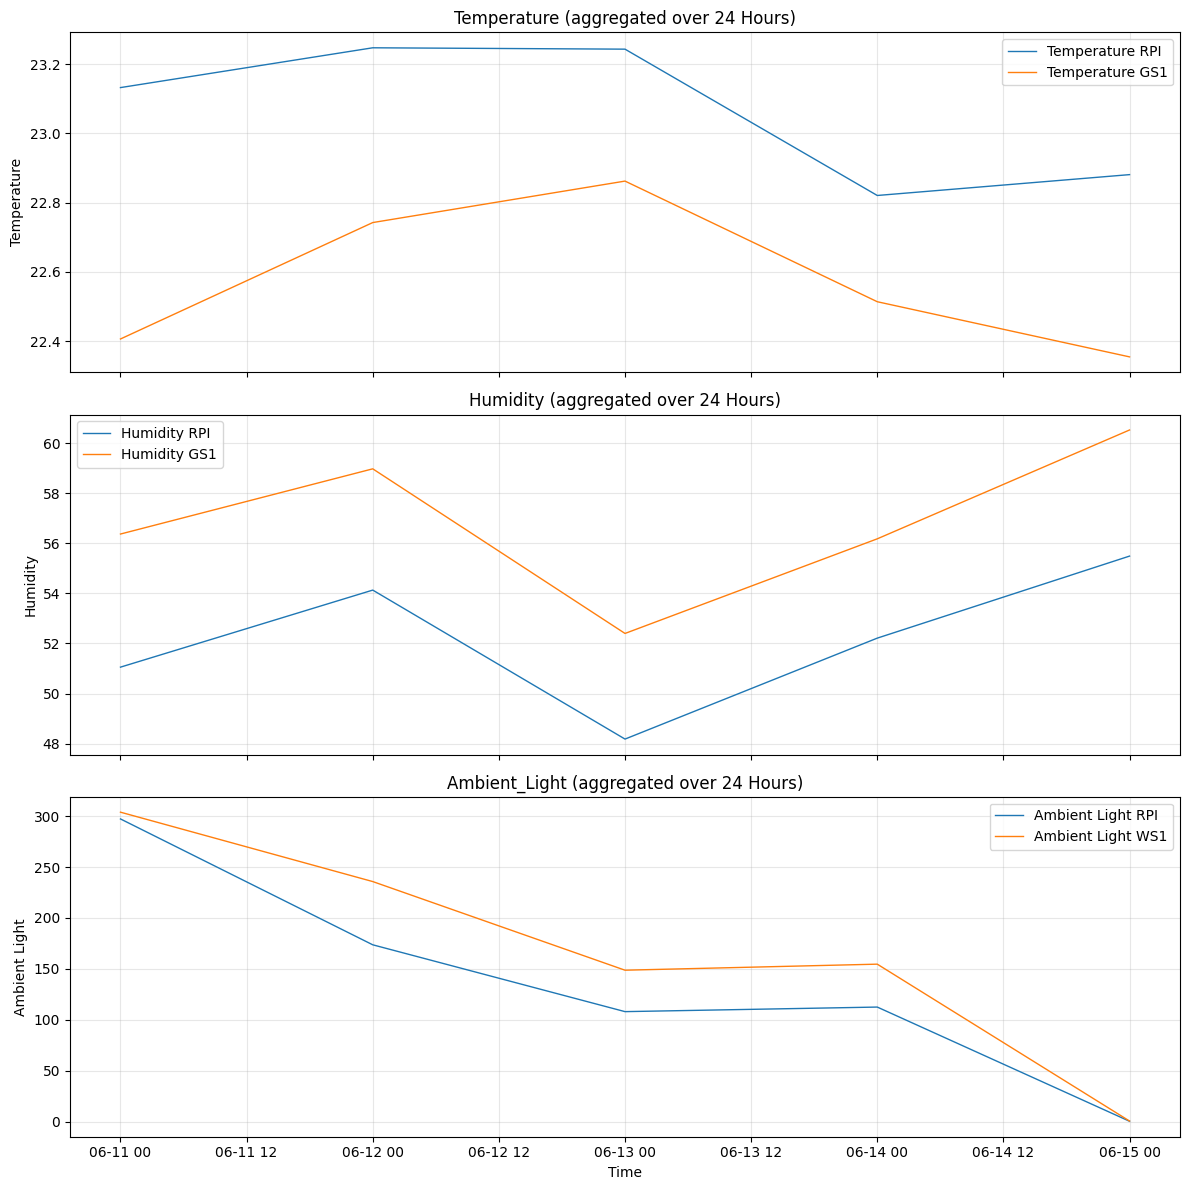

In [65]:
# 8. Aggregated time-window visualizations
agg_periods = {
    '10 Minutes': '10min',
    '1 Hour':     '1h',
    '12 Hours':   '12h',
    '24 Hours':   '24h'
}
for period_name, rule in agg_periods.items():
    # resample & mean-aggregate
    agg_df = fused_data.resample(rule).mean()

    # one subplot row per feature
    fig, axes = plt.subplots(
        nrows=len(features), ncols=1,
        figsize=(12, 4 * len(features)),
        sharex=True
    )
    if len(features) == 1:
        axes = [axes]

    for ax, (feat, cols) in zip(axes, features.items()):
        for col in cols:
            if col in agg_df.columns:
                ax.plot(
                    agg_df.index,
                    agg_df[col],
                    label=col.replace('_', ' '),
                    linewidth=1
                )
        ax.set_title(f"{feat} (aggregated over {period_name})")
        ax.set_ylabel(feat.replace('_', ' '))
        ax.legend()
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()

### ML Visualizations
----

Text(0.5, 1.0, 'Calibration Model Performance')

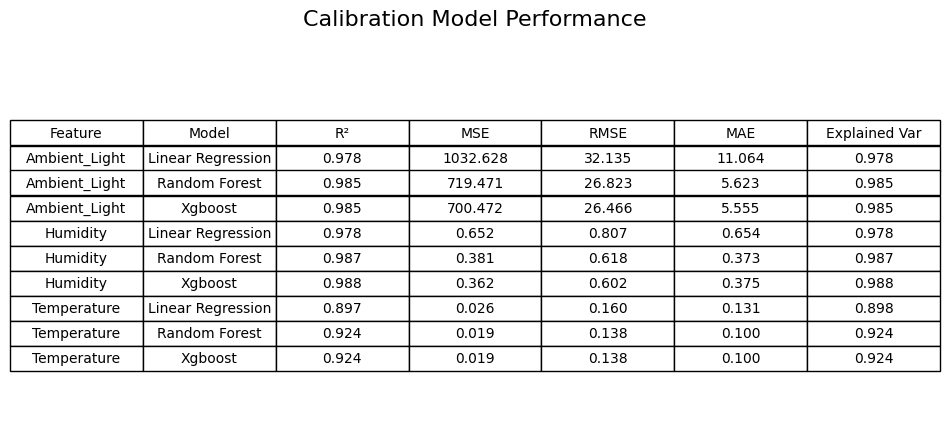

In [66]:
# Calibration metrics summary table
fig, ax = plt.subplots(figsize=(12, 0.5 + 0.5 * sum(len(m) for m in calibration_results.values())))
ax.axis('tight'); ax.axis('off')
metrics_data = []
for feat, methods in calibration_results.items():
    for method, res in methods.items():
        metrics_data.append([
            feat.title(), method.replace('_', ' ').title(),
            f"{res['r2']:.3f}", f"{res['mse']:.3f}",
            f"{res['rmse']:.3f}", f"{res['mae']:.3f}", f"{res['explained_variance']:.3f}"
        ])
cols = ['Feature', 'Model', 'R²', 'MSE', 'RMSE', 'MAE', 'Explained Var']
table = ax.table(
    cellText=metrics_data, colLabels=cols, cellLoc='center', loc='center'
)
table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1, 1.5)
plt.title('Calibration Model Performance', fontsize=16, pad=20)


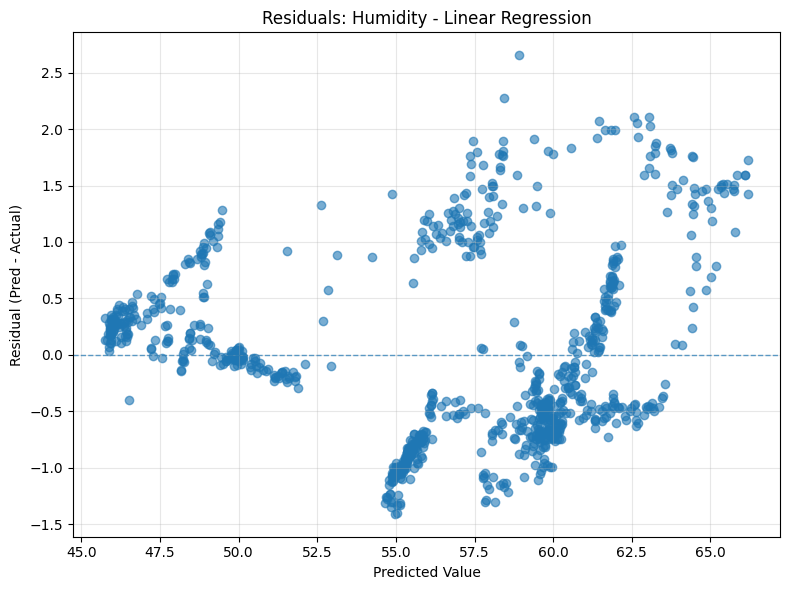

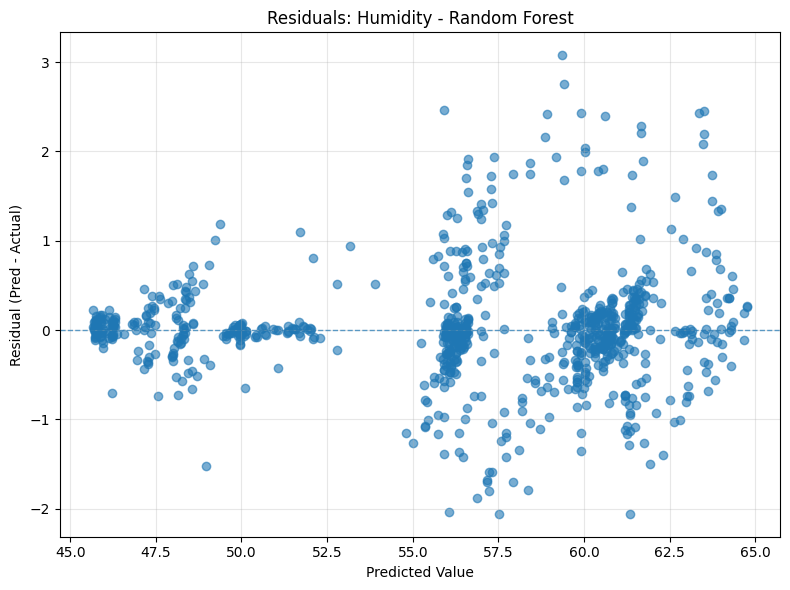

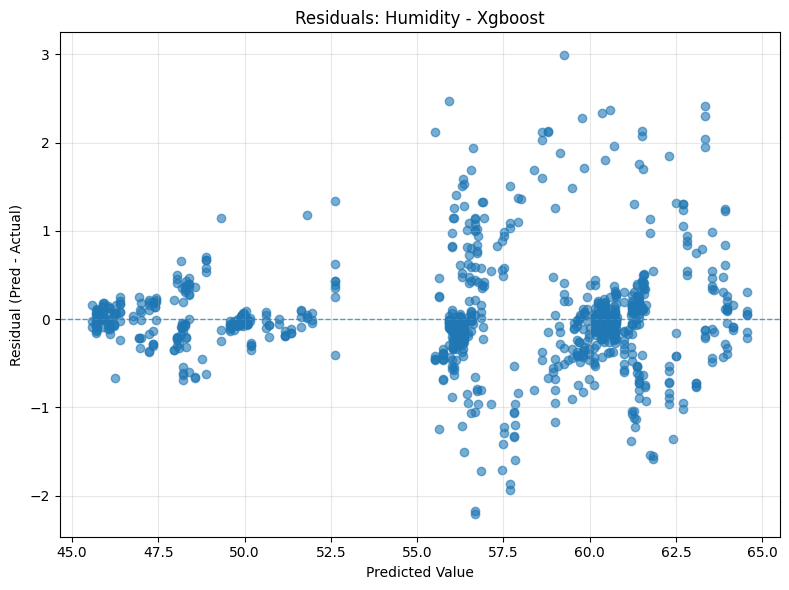

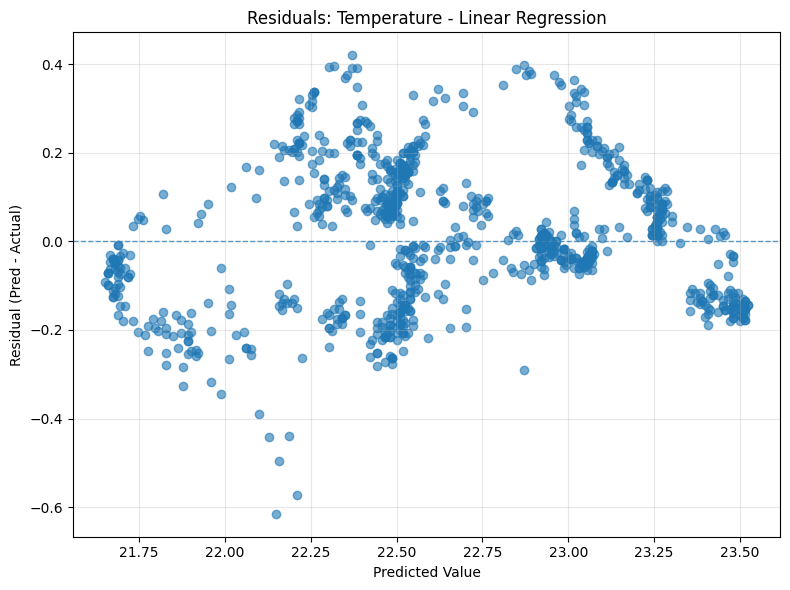

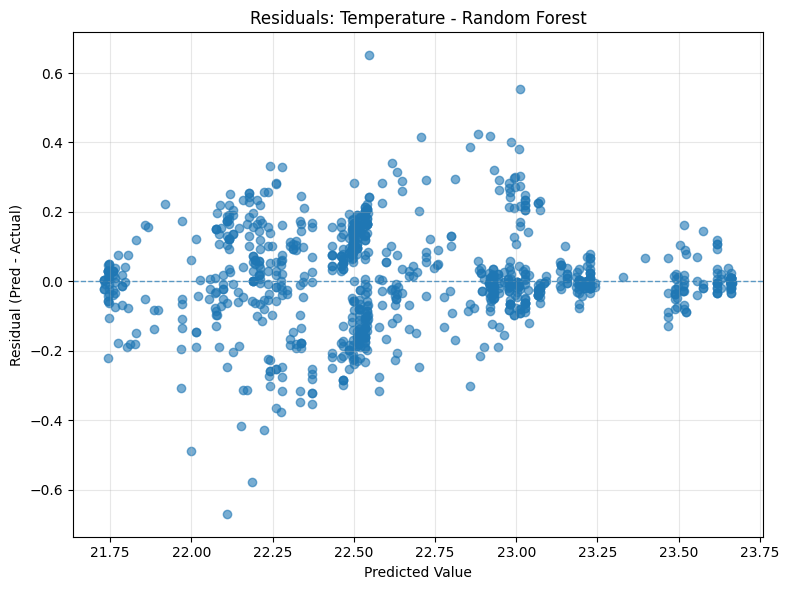

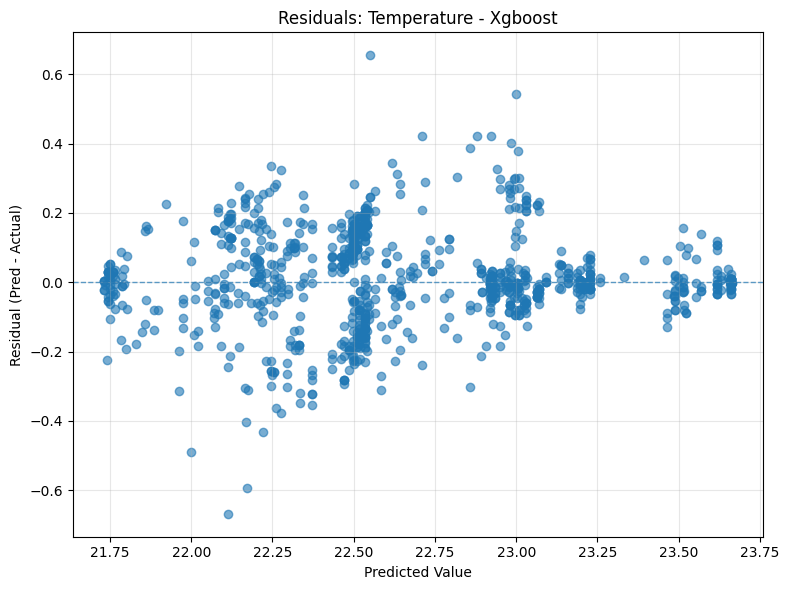

In [67]:
# Residual plots for each feature/model
for feat, methods in calibration_results.items():
    ref_col = f"{feat.title()}_GS1" if feat.title() + '_GS1' in fused_data.columns else None
    for method in methods:
        pred_col = f"{feat.title()}_RPI_{method}"
        if ref_col and pred_col in fused_data.columns:
            residuals = fused_data[pred_col] - fused_data[ref_col]
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.scatter(fused_data[pred_col], residuals, alpha=0.6)
            ax.axhline(0, linestyle='--', linewidth=1, alpha=0.7)
            ax.set_xlabel('Predicted Value')
            ax.set_ylabel('Residual (Pred - Actual)')
            ax.set_title(f'Residuals: {feat.title()} - {method.replace('_', ' ').title()}')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

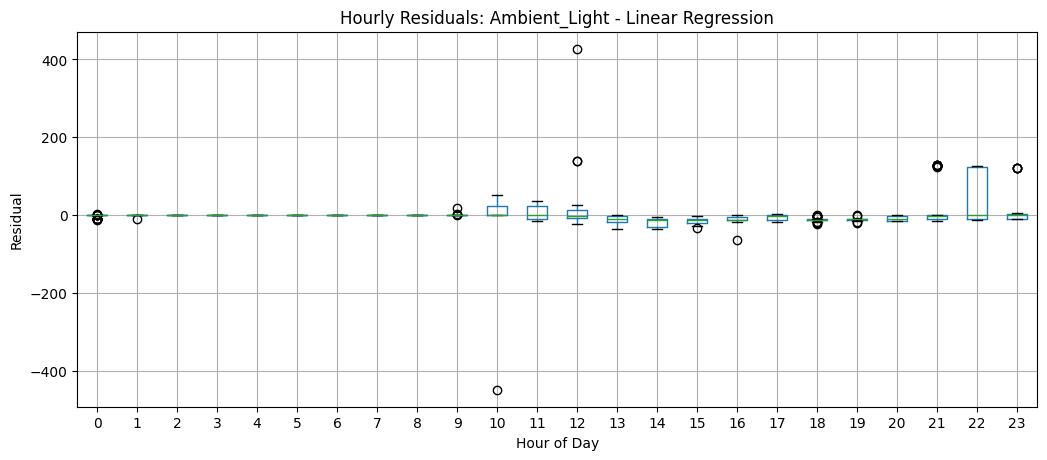

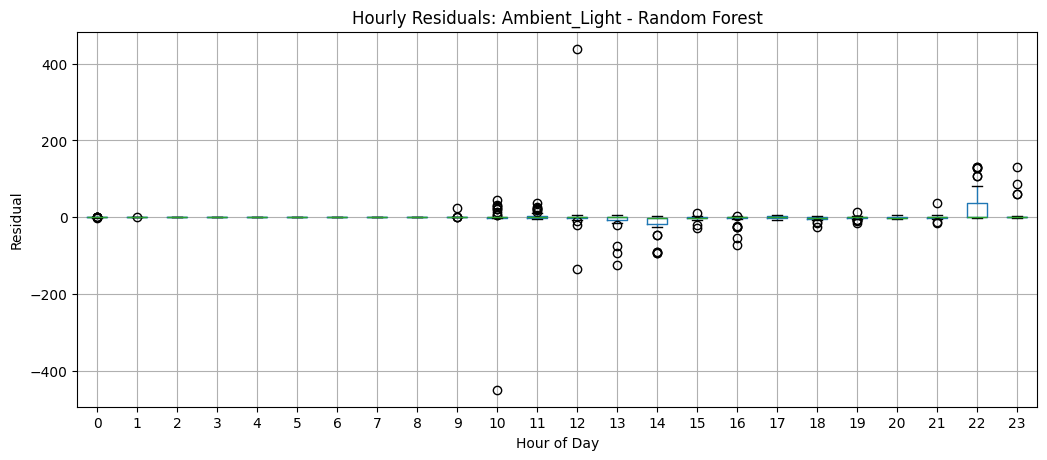

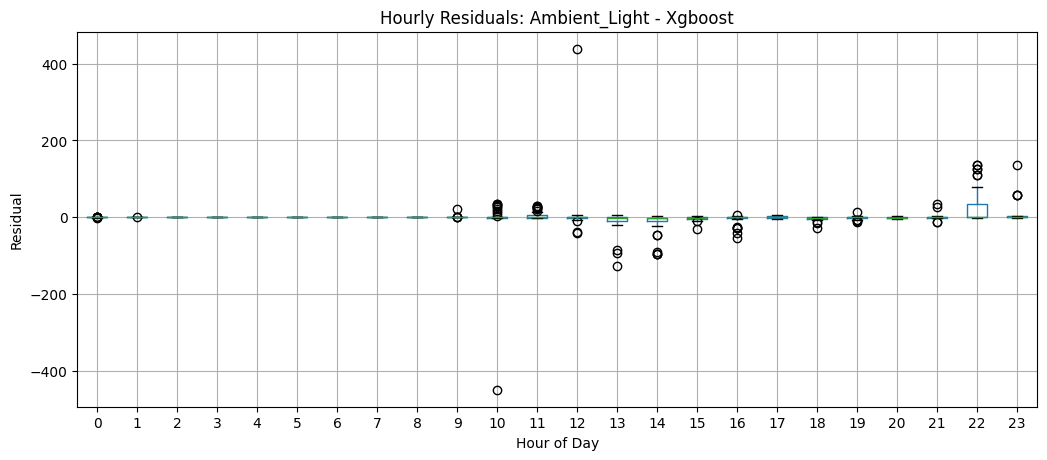

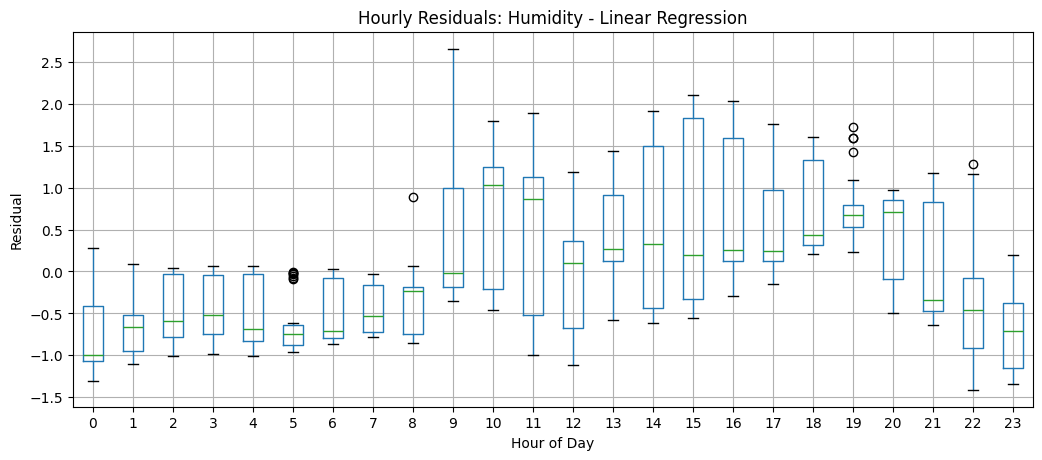

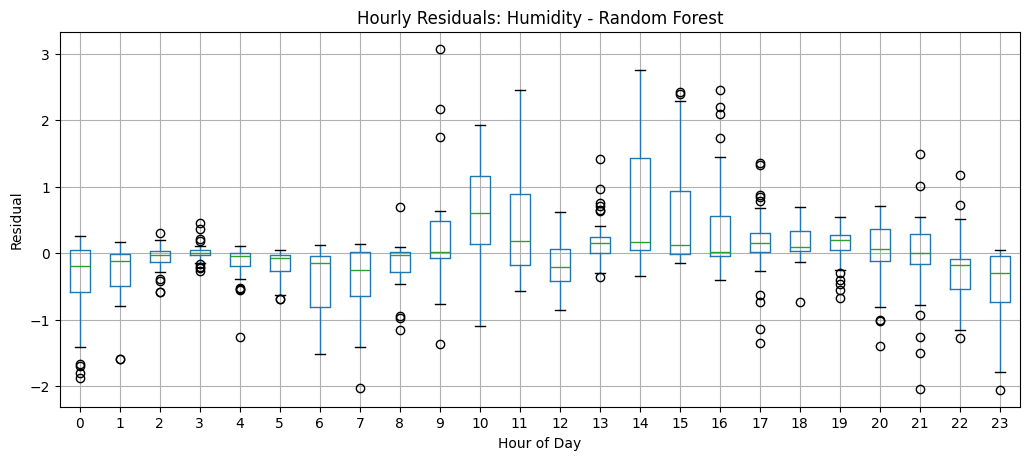

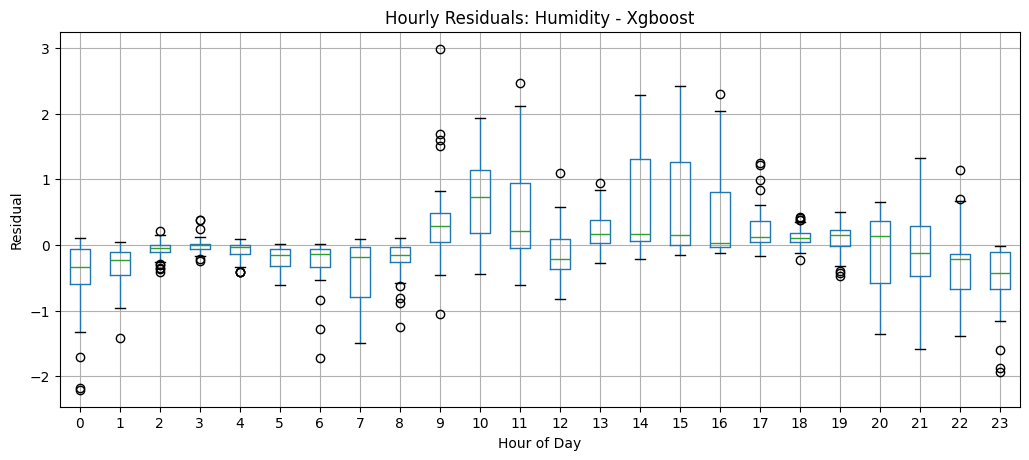

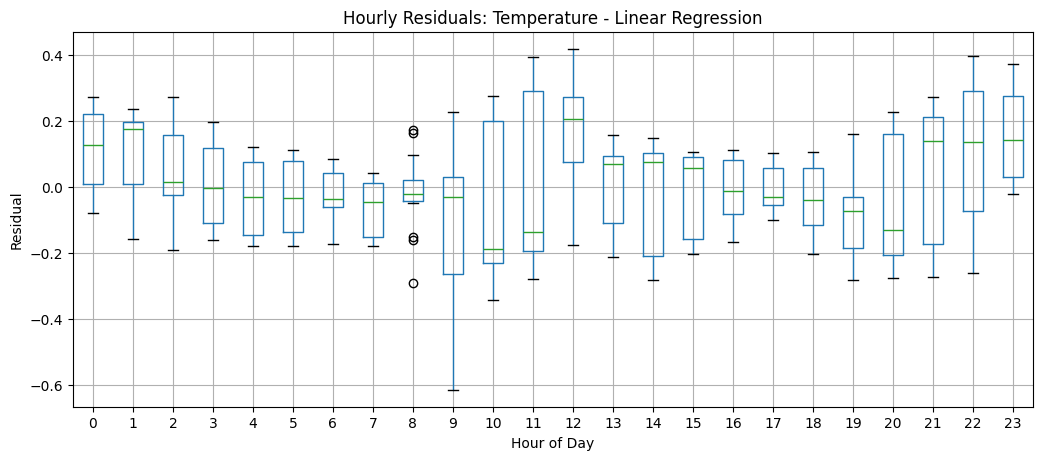

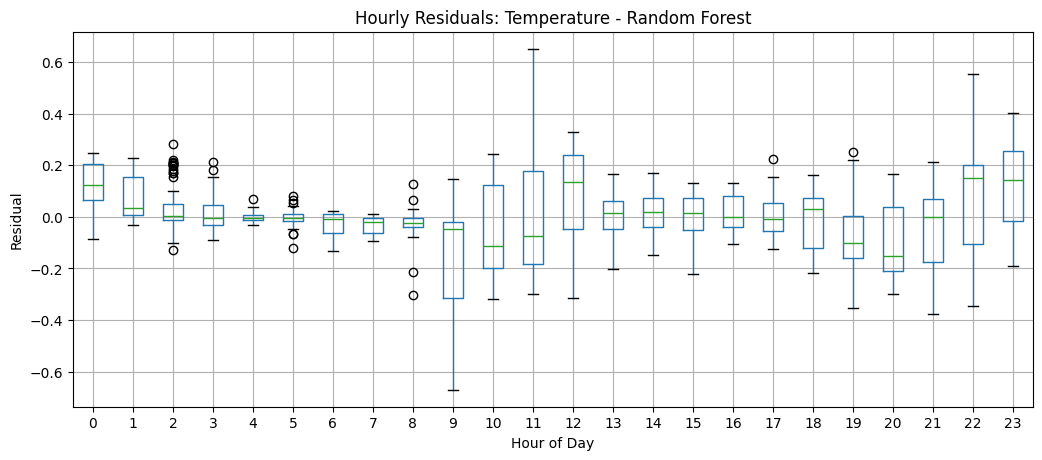

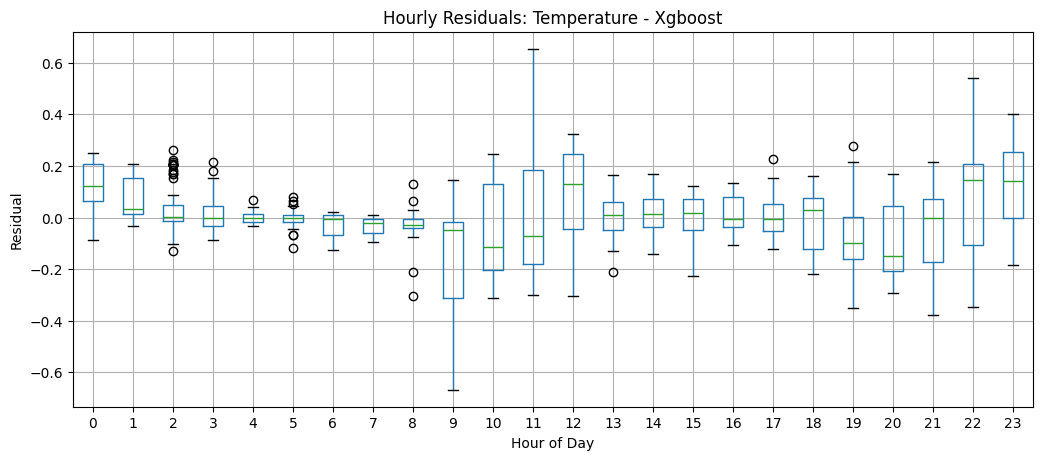

In [68]:
fused_data['hour'] = fused_data.index.hour
for feat, methods in calibration_results.items():
    ref_col = next((c for c in fused_data.columns if c.startswith(feat.title()) and ('_GS1' in c or '_WS1' in c)), None)
    for method in methods:
        pred_col = f"{feat.title()}_RPI_{method}"
        if ref_col and pred_col in fused_data.columns:
            fig, ax = plt.subplots(figsize=(12,5))
            fused_data['residual'] = fused_data[pred_col] - fused_data[ref_col]
            fused_data.boxplot(column='residual', by='hour', ax=ax)
            ax.set_title(f'Hourly Residuals: {feat.title()} - {method.replace("_"," ").title()}')
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel('Residual')
            plt.suptitle('')
